In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

env = gym.make('CartPole-v1').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print(env.action_space)
print(env.observation_space)
print(device)

#Code is inspired from Pytorch tutorial

Discrete(2)
Box(4,)
cuda


<h3>Preprocess frames</h3>

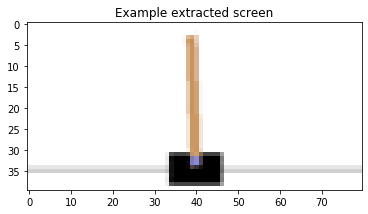

torch.Size([1, 3, 40, 80])


In [11]:
resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.CUBIC), T.ToTensor()])

# This is based on the code from gym.
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

print(get_screen().shape)

<h3>Experience Replay Buffer </h3>

In [3]:
# Transisition tuple to store
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

<h3>Priortized Experience Buffer</h3>

In [4]:
class Priortized_Replay_Memory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.alpha = 0.6
        self.priorities = np.zeros((self.capacity,), dtype=np.float32)

    def push(self, *args):
        """Saves a transition."""
        max_priority = self.priorities.max() if self.memory else 1.0
        if len(self.memory) < self.capacity:
            self.memory.append(Transition(*args))
        self.memory[self.position] = Transition(*args)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.memory) == self.capacity:
            priority_values = self.priorities
        else:
            priority_values = self.priorities[:self.position]
        
        probs  = priority_values ** self.alpha
        probs /= probs.sum()
        
        samples_index = np.random.choice(len(self.memory), batch_size, p=probs)
        samples = [self.memory[index] for index in samples_index]
        return samples, samples_index
#         return random.sample(self.memory, batch_size)
    
    def set_priorities(self, addresses, priority_values):
        print(priority_values)
        print(addresses.shape)
        for index, priority in zip(addresses, priority_values):
            self.priorities[index] = priority

    def __len__(self):
        return len(self.memory)

<h3>Neural Network Model</h3>

In [5]:
class Neural_Network(nn.Module):

#     def __init__(self, h, w, outputs):
#         super(Neural_Network, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
#         self.bn3 = nn.BatchNorm2d(128)
        
#         def conv2d_size_out(size, kernel_size = 4, stride = 2):
#             return (size - (kernel_size - 1) - 1) // stride  + 1
        
#         convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w, 8, 4), 4, 2), 3, 1)
#         convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h, 8, 4), 4, 2), 3, 1)
#         self.head = nn.Linear(convw * convh * 128, outputs)


#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.relu(self.bn3(self.conv3(x)))
#         return self.head(x.view(x.size(0), -1))
    
    def __init__(self, h, w, outputs):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
    

        

<h3>Hyperparameters and Initialisation</h3>

In [12]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape


policy_net = Neural_Network(screen_height, screen_width, env.action_space.n).to(device)
target_net = Neural_Network(screen_height, screen_width, env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

print(policy_net)

optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)
memory = ReplayMemory(20000)
# memory = Priortized_Replay_Memory(10000)


steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
#     print(eps_threshold)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(env.action_space.n)]], device=device, dtype=torch.long)




Neural_Network(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=448, out_features=2, bias=True)
)


<h3>Model update function </h3>
<p></p>

In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

<h3>Training</h3>

In [8]:
num_episodes = 500
total_rewards= []
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    r = 0
    for t in count():
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        
#         if len(memory) < BATCH_SIZE:
#             i_episode = 0
#             break;
        optimize_model()
        r += reward.item()
        if done:
            break
    # Update the target network
    if i_episode % TARGET_UPDATE == 0 or r > 100:
        target_net.load_state_dict(policy_net.state_dict())
    total_rewards.append(r)


Complete


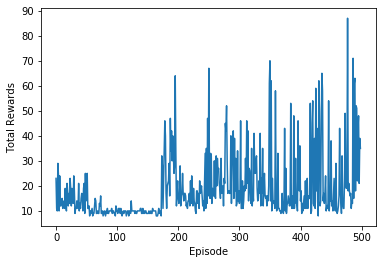

In [9]:
print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

window = 1
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.plot([np.mean(total_rewards[tr:tr+window]) for tr in range(window, len(total_rewards))])

18.836
0


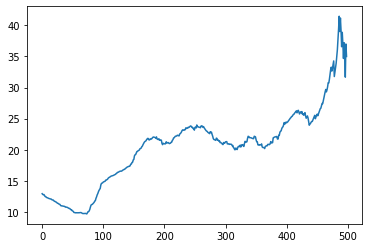

In [10]:
print(np.mean(total_rewards))
print(np.count_nonzero(np.array(total_rewards) > 100))
plt.plot([np.mean(total_rewards[tr:tr+100]) for tr in range(window, len(total_rewards))])